In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sparse_stoch_mat_central as sp_stoch_mat
import sys
from scipy.sparse.linalg import spsolve
import timeit
sys.path.append('/home/hcleroy/Extra_Module_py/')
from formated_matplotlib import *
from functions import *

## Equation differential of the problem :
$$ 
\begin{cases}
&\partial_t \rho_a = \partial_x^2 \rho_a +\partial_x[\rho_a \partial_x V_a]  \rho_c k_{ca} - \rho_a+k_{ab}\\
&\partial_t \rho_b = \partial_x^2 \rho_b + \rho_a k_{ab} - \rho_b k_{bc}\\
&\partial_t \rho_c = \partial_x^2 \rho_c  + \rho_b k_{bc} - \rho_c k_{ca}\\
\end{cases}
$$
with :
$$
\begin{cases}
& k_{CA} = \\
& k_{AB} = \\
& k_{BC} = \\
\end{cases}
$$

Check the notes : SimplifiedModel

In [3]:
# Common Parameters :
size = 20
VABC0= [1.,0.,0.]
steepA,steepB,steepC = 1,1,1
Eabcabc = [20.0,0.0,0.0]#0.01,0.02,0.03
Aab,Abc,Aac = 1.,1.,1.

kbc0,kac0 = 1.,1.
kab0=1. # !!!!!!!!!!! this is not an adjustable parameter !!!!!!!!!!!!!!!!!

# stochastic matrix parameters :
X0,Xf,n = 0,size,10000 # lower/higher spacial boundary and number of discretizing points
dx = (Xf-X0)/n
print('dx_{SM} = '+str(dx))

def get_VABC(steeps):
    va = lambda x : 1/2*(1+np.tanh((x-size/2)*steeps[0]))
    vb = lambda x : 1/2*(1+np.tanh((x-size/2)*steeps[1]))
    vc = lambda x : 1/2*(1+np.tanh((x-size/2)*steeps[2]))

    #va = lambda x : 1. if x < size//2 else 0.
    #vb = lambda x : 0. if x < size//2 else 1.
    #vc = lambda x : 1. if x < size//2 else 0.
    # define all the Vs :
    def VA(X):
        try:
            if X.shape[0] == 3:
                return va(X[0])
            else:
                raise ValueError
        except:
            return va(X)
    def VB(X):
        try:
            if X.shape[0] == 3:
                return vb(X[0])
            else:
                raise ValueError
        except:
            return vb(X)
    def VC(X):
        try:
            if X.shape[0] == 3:
                return vc(X[0])
            else:
                raise ValueError
        except:
            return vc(X)
    return VA,VB,VC

#lambda X,*arg : np.array([0. for x in X]) if type(X) == np.ndarray else 0.#
def get_ks(steeps,VABC0,Eab_ca_bc,DeltaMu):
    VA,VB,VC = get_VABC(steeps)
    VAB0 = VABC0[0]
    VCA0 = VABC0[0]
    kab = lambda X,*arg : np.array([ np.exp(-(Eab_ca_bc[0]+(VAB0-VABC0[0])*VA(x)-DeltaMu)) for x in X]) if type(X) == np.ndarray else  np.exp(-(Eab_ca_bc[0]+VAB0*VA(X)-DeltaMu))
    kba = lambda X,*arg : np.array([0. for x in X]) if type(X) == np.ndarray else 0.
    kbc = lambda X,*arg : np.array([ np.exp(-(Eab_ca_bc[2])) for x in X]) if type(X) == np.ndarray else np.exp(-(Eab_ca_bc[2]))
    kcb = lambda X,*arg : np.array([0. for x in X]) if type(X) == np.ndarray else 0.
    kac = lambda X,*arg : np.array([0. for x in X]) if type(X) == np.ndarray else 0.
    kca = lambda X,*arg : np.array([ np.exp(-(Eab_ca_bc[1]+VCA0*VA(x))) for x in X]) if type(X) == np.ndarray else np.exp(-(Eab_ca_bc[1]-VCA0*VA(X)))
    return VA,VB,VC,kab,kba,kbc,kcb,kac,kca


dx_{SM} = 0.002


In [4]:
# steep = 1.
va1,vb1,vc1,kab1,kba1,kbc1,kcb1,kac1,kca1 = get_ks([1.,1.,1.],VABC0,Eabcabc,20)
VA1 = lambda X: VABC0[0]*va1(X)
VB1 = lambda X: VABC0[1]*vb1(X)
VC1 = lambda X: VABC0[2]*vc1(X)
Ooe_Stoch_Mat = sp_stoch_mat.make_transition_matrix(VA1,VB1,VC1,
                                    kab1,kba1,kbc1,kcb1,kac1,kca1,
                                    kab0,kbc0,kac0,
                                    Aab=1,Abc=1,Aac=1,
                                    X0=X0,Xf=Xf,n=n)
rho_a_ooe1,rho_b_ooe1,rho_c_ooe1 = get_kernel_stoch_mat(Ooe_Stoch_Mat,dx)

In [5]:
va,vb,vc = get_VABC([1.,1.,1.])
EA,EB,EC = 0.,20.,10.
VA = lambda X : va(X)*VABC0[0]+EA
VB = lambda X : vb(X)*VABC0[1]+EB
VC = lambda X : vc(X)*VABC0[2]+EC
rho_a_diff,rho_b_diff,rho_c_diff = make_eq_distrib(VA,VB,VC,np.linspace(X0,Xf,n,endpoint=False))
Z = (sum(rho_a_diff)+sum(rho_b_diff)+sum(rho_c_diff))*dx
# normalize the diffusion part :
rho_a_diff,rho_b_diff,rho_c_diff =rho_a_diff/Z,rho_b_diff/Z,rho_c_diff/Z

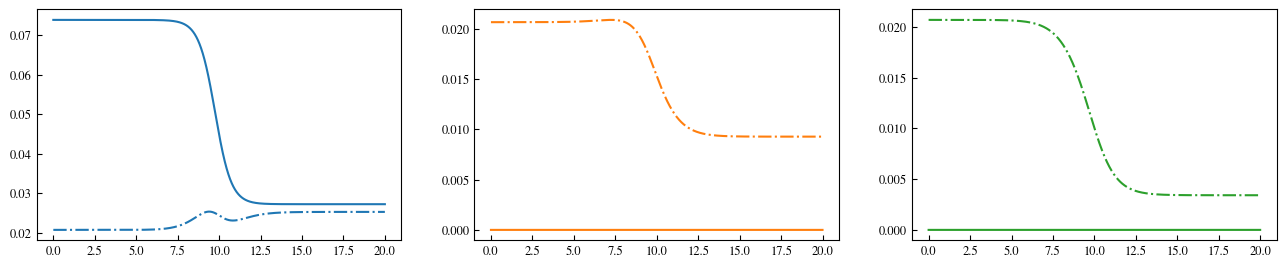

In [6]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

X = np.linspace(X0,Xf,n,endpoint=False)

ax[0].plot(X,rho_a_diff,color=ColorCycle[0])
ax[1].plot(X,rho_b_diff,color=ColorCycle[1])
ax[2].plot(X,rho_c_diff,color=ColorCycle[2])

ax[0].plot(X,rho_a_ooe1,color = ColorCycle[0],linestyle='-.',label='steep = 1')
ax[1].plot(X,rho_b_ooe1,color = ColorCycle[1],linestyle='-.',label='steep = 1')
ax[2].plot(X,rho_c_ooe1,color = ColorCycle[2],linestyle='-.',label='steep = 1')

In [7]:
A_ooe__diff_flux1 = diff_flux(rho_a_ooe1,VA1(X),dx)
B_ooe__diff_flux1 = diff_flux(rho_b_ooe1,VB1(X),dx)
C_ooe__diff_flux1 = diff_flux(rho_c_ooe1,VC1(X),dx)


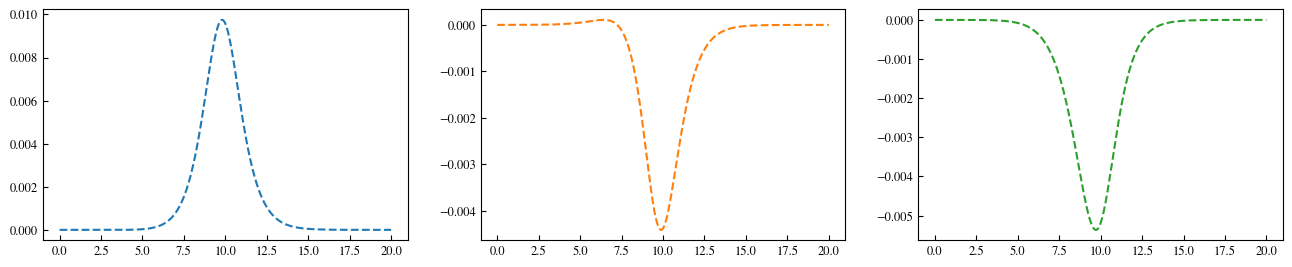

In [8]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

X = np.linspace(X0,Xf,n,endpoint=False)


ax[0].plot(X,A_ooe__diff_flux1,color = ColorCycle[0],linestyle='--',label='steep = 1')
ax[1].plot(X,B_ooe__diff_flux1,color = ColorCycle[1],linestyle='--',label='steep = 1')
ax[2].plot(X,C_ooe__diff_flux1,color = ColorCycle[2],linestyle='--',label='steep = 1')